# 风格迁移

摄影爱好者也许接触过**滤波器。它能改变照片的颜色风格**，从而使风景照更加锐利或者令人像更加美白。但一个滤波器通常只能改变照片的某个方面。如果要照片达到理想中的风格，可能需要尝试大量不同的组合。这个过程的复杂程度不亚于模型调参。

本节将介绍如何使用卷积神经网络，**自动将一个图像中的风格应用在另一图像之上，即风格迁移**（style transfer） :cite:`Gatys.Ecker.Bethge.2016`。
这里我们需要两张输入图像：一张是**内容图像**，另一张是**风格图像**。
**我们将使用神经网络修改内容图像，使其在风格上接近风格图像。**

例如， `fig_style_transfer` 中的内容图像为本书作者在西雅图郊区的雷尼尔山国家公园拍摄的风景照，而风格图像则是一幅主题为秋天橡树的油画。
最终输出的合成图像应用了风格图像的油画笔触让整体颜色更加鲜艳，同时保留了内容图像中物体主体的形状。

![输入内容图像和风格图像，输出风格迁移后的合成图像](img/style-transfer.svg)

## 方法

`fig_style_transfer_model`用简单的例子阐述了基于卷积神经网络的风格迁移方法。
**首先，我们初始化合成图像，例如将其初始化为内容图像。**
**该合成图像是风格迁移过程中唯一需要更新的变量，即风格迁移所需迭代的模型参数。**
然后，我们选择一个预训练的卷积神经网络来抽取图像的特征，**其中的模型参数在训练中无须更新。**
这个深度卷积神经网络凭借多个层逐级抽取图像的特征，**我们可以选择其中某些层的输出作为内容特征或风格特征。**

以 `fig_style_transfer_model` 为例，这里选取的预训练的神经网络含有3个卷积层，**其中第二层输出内容特征，第一层和第三层输出风格特征。**

![基于卷积神经网络的风格迁移。实线箭头和虚线箭头分别表示前向传播和反向传播](img/neural-style.svg)

接下来，**我们通过前向传播（实线箭头方向）计算风格迁移的损失函数，并通过反向传播（虚线箭头方向）迭代模型参数，即不断更新合成图像。**
风格迁移常用的损失函数由3部分组成：

1. **内容损失**使合成图像与内容图像在内容特征上接近；
1. **风格损失**使合成图像与风格图像在风格特征上接近；
1. **全变分损失**则有助于减少合成图像中的噪点。

**最后，当模型训练结束时，我们输出风格迁移的模型参数，即得到最终的合成图像。**



在下面，我们将通过代码来进一步了解风格迁移的技术细节。

## [**阅读内容和风格图像**]

首先，我们读取内容和风格图像。
从打印出的图像坐标轴可以看出，**它们的尺寸并不一样。**


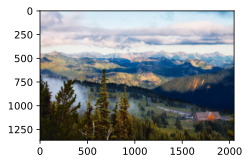

In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from d2l import torch as d2l

d2l.set_figsize()
content_img = d2l.Image.open('img/rainier.jpg')
d2l.plt.imshow(content_img);

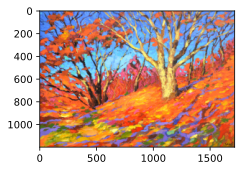

In [2]:
style_img = d2l.Image.open('img/autumn-oak.jpg')
d2l.plt.imshow(style_img);

## [**预处理和后处理**]

下面，定义图像的预处理函数和后处理函数。
**预处理函数`preprocess`对输入图像在RGB三个通道分别做标准化，并将结果变换成卷积神经网络接受的输入格式。**
**后处理函数`postprocess`则将输出图像中的像素值还原回标准化之前的值。**
**由于图像打印函数要求每个像素的浮点数值在0～1之间**，我们对小于0和大于1的值分别取0和1。


In [3]:
# 定义均值和标准差用于图像归一化
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

# 图像预处理函数，将输入图像转换为模型可用的格式
def preprocess(img, image_shape):
    # 创建一个图像变换序列，包括调整大小、转换为张量和归一化
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),  # 调整图像大小
        torchvision.transforms.ToTensor(),  # 将图像转换为张量
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)  # 归一化图像
    ])
    # 应用变换并在最终张量上添加一个批次维度
    return transforms(img).unsqueeze(0)

# 图像后处理函数，将模型输出的张量转换回图像
def postprocess(img):
    # 从模型输出张量中移除批次维度，并将其移动到与标准差张量相同的设备上
    img = img[0].to(rgb_std.device)
    # 反归一化图像并将通道顺序从（C，H，W）更改为（H，W，C）
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    # 将张量转换回PIL图像
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))


## [**抽取图像特征**]

我们使用基于ImageNet数据集预训练的VGG-19模型来抽取图像特征 :cite:`Gatys.Ecker.Bethge.2016`。


In [4]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/home/corner/.conda/envs/corner/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/corner/.conda/envs/corner/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
pretrained_net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padd

为了抽取图像的内容特征和风格特征，我们可以选择VGG网络中某些层的输出。
一般来说，越靠近输入层，越容易抽取图像的细节信息；反之，则越容易抽取图像的全局信息。
**为了避免合成图像过多保留内容图像的细节，我们选择VGG较靠近输出的层，即内容层，来输出图像的内容特征。**
我们还从VGG中选择不同层的输出来匹配局部和全局的风格，这些图层也称为**风格层**。
正如 `sec_vgg` 中所介绍的，VGG网络使用了5个卷积块。
实验中，**我们选择第四卷积块的最后一个卷积层作为内容层，选择每个卷积块的第一个卷积层作为风格层。**
这些层的索引可以通过打印`pretrained_net`实例获取。


In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

**使用VGG层抽取特征时，我们只需要用到从输入层到最靠近输出层的内容层或风格层之间的所有层。**
下面构建一个新的网络`net`，它只保留需要用到的VGG的所有层。


In [7]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

给定输入`X`，如果我们简单地调用前向传播`net(X)`，只能获得最后一层的输出。
**由于我们还需要中间层的输出，因此这里我们逐层计算，并保留内容层和风格层的输出。**


In [8]:
def extract_features(X, content_layers, style_layers):
    """
    从神经网络中提取内容和风格特征。

    参数:
    - X: 输入图像张量
    - content_layers: 包含内容特征的层的索引列表
    - style_layers: 包含风格特征的层的索引列表

    返回:
    - contents: 包含提取的内容特征的张量列表
    - styles: 包含提取的风格特征的张量列表
    """
    contents = []  # 用于存储内容特征的列表
    styles = []    # 用于存储风格特征的列表

    # 遍历神经网络的所有层并提取特征
    for i in range(len(net)):
        X = net[i](X)  # 通过网络的当前层传递输入张量

        # 如果当前层的索引在style_layers列表中，将特征添加到styles列表中
        if i in style_layers:
            styles.append(X)

        # 如果当前层的索引在content_layers列表中，将特征添加到contents列表中
        if i in content_layers:
            contents.append(X)

    # 返回提取的内容和风格特征
    return contents, styles


下面定义两个函数：`get_contents`函数对内容图像抽取内容特征；
`get_styles`函数对风格图像抽取风格特征。
**因为在训练时无须改变预训练的VGG的模型参数，所以我们可以在训练开始之前就提取出内容特征和风格特征。**
由于合成图像是风格迁移所需迭代的模型参数，我们只能在训练过程中通过调用`extract_features`函数来抽取合成图像的内容特征和风格特征。


In [9]:
def get_contents(image_shape, device):
    """
    获取内容图像的内容特征。

    参数:
    - image_shape: 指定图像形状的元组（高度，宽度）
    - device: 指定计算设备（如CPU或GPU）

    返回:
    - content_X: 预处理后的内容图像张量
    - contents_Y: 内容图像的内容特征张量列表
    """
    # 预处理内容图像并将其移动到指定设备上
    content_X = preprocess(content_img, image_shape).to(device)

    # 从内容图像中提取内容特征
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)

    # 返回内容图像张量和内容特征张量列表
    return content_X, contents_Y

def get_styles(image_shape, device):
    """
    获取风格图像的风格特征。

    参数:
    - image_shape: 指定图像形状的元组（高度，宽度）
    - device: 指定计算设备（如CPU或GPU）

    返回:
    - style_X: 预处理后的风格图像张量
    - styles_Y: 风格图像的风格特征张量列表
    """
    # 预处理风格图像并将其移动到指定设备上
    style_X = preprocess(style_img, image_shape).to(device)

    # 从风格图像中提取风格特征
    _, styles_Y = extract_features(style_X, content_layers, style_layers)

    # 返回风格图像张量和风格特征张量列表
    return style_X, styles_Y


## [**定义损失函数**]

下面我们来描述风格迁移的损失函数。
**它由内容损失、风格损失和全变分损失3部分组成。**

### 内容损失

与线性回归中的损失函数类似，**内容损失通过平方误差函数衡量合成图像与内容图像在内容特征上的差异。**
平方误差函数的两个输入均为`extract_features`函数计算所得到的内容层的输出。


In [10]:
def content_loss(Y_hat, Y):
    # 我们从动态计算梯度的树中分离目标：
    # 这是一个规定的值，而不是一个变量。
    return torch.square(Y_hat - Y.detach()).mean()

### 风格损失

**风格损失与内容损失类似，也通过平方误差函数衡量合成图像与风格图像在风格上的差异。**
为了表达风格层输出的风格，我们先通过`extract_features`函数计算风格层的输出。
假设该输出的样本数为1，**通道数为$c$**，高和宽分别为$h$和$w$，我们可以将此输出转换为矩阵$\mathbf{X}$，其有$c$行和$hw$列。
这个矩阵可以被看作由$c$个长度为$hw$的向量$\mathbf{x}_1, \ldots, \mathbf{x}_c$组合而成的。**其中向量$\mathbf{x}_i$代表了通道$i$上的风格特征。**

在这些向量的**格拉姆矩阵**$\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$中，$i$行$j$列的元素$x_{ij}$即向量$\mathbf{x}_i$和$\mathbf{x}_j$的内积。**它表达了通道$i$和通道$j$上风格特征的相关性。我们用这样的格拉姆矩阵来表达风格层输出的风格。**
需要注意的是，当$hw$的值较大时，格拉姆矩阵中的元素容易出现较大的值。
此外，格拉姆矩阵的高和宽皆为通道数$c$。
**为了让风格损失不受这些值的大小影响，下面定义的`gram`函数将格拉姆矩阵除以了矩阵中元素的个数，即$chw$。**


In [11]:
def gram(X):
    # 获取输入张量的通道数和每个通道的像素数量
    num_channels, n = X.shape[1], X.numel() // X.shape[1]

    # 将输入张量重新形状为一个二维矩阵，其中行对应于通道，列对应于像素
    X = X.reshape((num_channels, n))

    # 计算Gram矩阵，即每个通道之间的内积
    gram_matrix = torch.matmul(X, X.T)

    # 对Gram矩阵进行标准化，以确保值在0到1之间
    gram_matrix /= (num_channels * n)

    # 返回计算得到的Gram矩阵，用于捕捉图像的风格信息
    return gram_matrix


**自然地，风格损失的平方误差函数的两个格拉姆矩阵输入分别基于合成图像与风格图像的风格层输出**。这里假设基于风格图像的格拉姆矩阵`gram_Y`已经预先计算好了。


In [12]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

### 全变分损失

**有时候，我们学到的合成图像里面有大量高频噪点，即有特别亮或者特别暗的颗粒像素。**
一种常见的去噪方法是**全变分去噪**（total variation denoising）：
假设$x_{i, j}$表示坐标$(i, j)$处的像素值，降低全变分损失

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

能够尽可能使邻近的像素值相似。


In [13]:
def tv_loss(Y_hat):
    """
    计算总变差损失，用于平滑图像。

    参数:
    - Y_hat: 输入张量，通常表示生成的图像或图像特征

    返回:
    - total_variation_loss: 总变差损失
    """
    # 计算垂直方向上的像素差异，并取其绝对值，然后计算平均值
    vertical_diff = torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean()

    # 计算水平方向上的像素差异，并取其绝对值，然后计算平均值
    horizontal_diff = torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean()

    # 总变差损失是垂直方向和水平方向上差异的平均值的一半
    total_variation_loss = 0.5 * (vertical_diff + horizontal_diff)

    # 返回总变差损失，用于平滑图像
    return total_variation_loss


### 损失函数

[**风格转移的损失函数是内容损失、风格损失和总变化损失的加权和**]。
**通过调节这些权重超参数**，我们可以权衡合成图像在保留内容、迁移风格以及去噪三方面的相对重要性。


In [14]:
# 定义内容、风格和全变分损失的权重
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    """
    计算总损失，包括内容损失、风格损失和全变分损失。

    参数:
    - X: 生成的图像张量
    - contents_Y_hat: 生成的图像的内容特征张量列表
    - styles_Y_hat: 生成的图像的风格特征张量列表
    - contents_Y: 目标内容图像的内容特征张量列表
    - styles_Y_gram: 目标风格图像的风格特征的Gram矩阵列表

    返回:
    - contents_l: 内容损失列表
    - styles_l: 风格损失列表
    - tv_l: 全变分损失
    - total_loss: 总损失
    """
    # 分别计算内容损失、风格损失和全变分损失
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight

    # 对所有损失求和，并用不同的权重调整它们的相对重要性
    total_loss = sum(styles_l + contents_l + [tv_l])

    # 返回内容损失、风格损失、全变分损失和总损失
    return contents_l, styles_l, tv_l, total_loss


## [**初始化合成图像**]

在风格迁移中，合成的图像是训练期间唯一需要更新的变量。因此，我们可以定义一个简单的模型`SynthesizedImage`，**并将合成的图像视为模型参数。模型的前向传播只需返回模型参数即可。**


In [15]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        """
        初始化合成图像生成模型。

        参数:
        - img_shape: 图像的形状（例如，(C, H, W) 其中 C 表示通道数，H 表示高度，W 表示宽度）
        - **kwargs: 其他可选参数
        """
        super(SynthesizedImage, self).__init__(**kwargs)

        # 创建一个可学习的参数作为合成图像的权重，初始化为随机值
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        """
        前向传播函数，返回合成图像的权重。

        返回:
        - self.weight: 合成图像的权重张量
        """
        return self.weight


下面，我们定义`get_inits`函数。该函数创建了合成图像的模型实例，并将其初始化为图像`X`。风格图像在各个风格层的格拉姆矩阵`styles_Y_gram`将在训练前预先计算好。


In [16]:
def get_inits(X, device, lr, styles_Y):
    """
    获取用于初始化生成图像、Gram矩阵和优化器的初始值。

    参数:
    - X: 输入图像张量，用于初始化生成图像
    - device: 计算设备（如CPU或GPU）
    - lr: 学习率，用于优化生成图像
    - styles_Y: 风格图像的风格特征的Gram矩阵列表

    返回:
    - gen_img: 初始化的生成图像模型
    - styles_Y_gram: 风格图像的风格特征的Gram矩阵列表
    - trainer: 优化器，用于调整生成图像的权重以匹配目标风格
    """
    # 创建一个合成图像生成模型，形状与输入图像相同，并将其移动到指定的计算设备上
    gen_img = SynthesizedImage(X.shape).to(device)

    # 将生成图像的权重初始化为输入图像的数据
    gen_img.weight.data.copy_(X.data)

    # 创建一个Adam优化器来调整生成图像的权重，使用指定的学习率
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)

    # 计算风格图像的风格特征的Gram矩阵，以用于后续的损失计算
    styles_Y_gram = [gram(Y) for Y in styles_Y]

    # 返回生成图像模型、风格图像的风格特征的Gram矩阵列表和优化器
    return gen_img(), styles_Y_gram, trainer


## [**训练模型**]

**在训练模型进行风格迁移时，我们不断抽取合成图像的内容特征和风格特征**，然后计算损失函数。下面定义了训练循环。


In [17]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    """
    训练图像生成模型，生成图像同时最小化内容损失、风格损失和全变分损失。

    参数:
    - X: 初始图像张量，用于生成图像的起点
    - contents_Y: 目标内容图像的内容特征张量列表
    - styles_Y: 风格图像的风格特征的Gram矩阵列表
    - device: 计算设备（如CPU或GPU）
    - lr: 初始学习率
    - num_epochs: 训练的总迭代次数
    - lr_decay_epoch: 学习率衰减的周期

    返回:
    - X: 训练后的生成图像
    """
    # 获取初始化的生成图像模型、风格图像的风格特征的Gram矩阵列表和优化器
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)

    # 创建一个学习率调度器，用于在每个lr_decay_epoch周期后衰减学习率
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)

    # 创建动画对象以可视化损失的变化
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(7, 2.5))

    # 迭代训练模型
    for epoch in range(num_epochs):
        trainer.zero_grad()

        # 提取生成图像的内容特征和风格特征
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)

        # 计算内容损失、风格损失和全变分损失
        contents_l, styles_l, tv_l, total_loss = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)

        # 反向传播并更新权重
        total_loss.backward()
        trainer.step()
        scheduler.step()

        # 在每10个周期绘制生成的图像和损失曲线
        if (epoch + 1) % 10 == 0:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])

    # 返回训练后的生成图像
    return X


现在我们[**训练模型**]：
首先将内容图像和风格图像的高和宽分别调整为300和450像素，**用内容图像来初始化合成图像。**


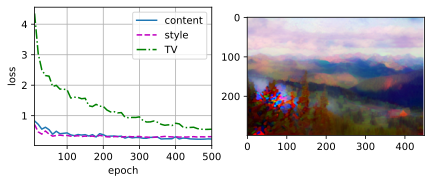

In [18]:
# 指定计算设备为GPU（如果可用），并设置图像形状
device, image_shape = d2l.try_gpu(), (300, 450)

# 将神经网络模型net移动到指定的计算设备上
net = net.to(device)

# 获取内容图像的内容特征内容图像和风格图像的风格特征
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)

# 使用训练函数生成满足内容和风格要求的图像
# 参数分别为初始图像、内容特征、风格特征、计算设备、学习率、训练周期数、学习率衰减周期
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)


我们可以看到，合成图像保留了内容图像的风景和物体，并同时迁移了风格图像的色彩。例如，合成图像具有与风格图像中一样的色彩块，其中一些甚至具有画笔笔触的细微纹理。

## 小结

* **风格迁移常用的损失函数由3部分组成：（1）内容损失使合成图像与内容图像在内容特征上接近；（2）风格损失令合成图像与风格图像在风格特征上接近；（3）全变分损失则有助于减少合成图像中的噪点。**
* 我们可以通过预训练的卷积神经网络来抽取图像的特征，并通过最小化损失函数来不断更新合成图像来作为模型参数。
* 我们使用格拉姆矩阵表达风格层输出的风格。

## 练习

1. 选择不同的内容和风格层，输出有什么变化？
1. 调整损失函数中的权重超参数。输出是否保留更多内容或减少更多噪点？
1. 替换实验中的内容图像和风格图像，能创作出更有趣的合成图像吗？
1. 我们可以对文本使用风格迁移吗？提示:可以参阅调查报告 :cite:`Hu.Lee.Aggarwal.ea.2020`。

[Discussions](https://discuss.d2l.ai/t/3300)
